In [221]:
# Utilities
from pathlib import Path
import os, sys
import subprocess as sp

# Data
import pandas as pd
import numpy as np

# Brain
import nibabel as nb
from nibabel.freesurfer.io import read_annot, read_label, read_morph_data, read_geometry
import cortex
import src.mesh_laplace_sulci

import gdist
import pygeodesic.geodesic as geodesic

# Plotting
from mpl_toolkits import mplot3d
# from mpl_toolkits.mplot3d import Axes3D
#%matplotlib inline
%matplotlib widget
import matplotlib.pyplot as plt

from utility_funcs import mris_convert_command

# Meshes
import igl
import meshplot 

from surface_funcs import * 




## Desired functions

1. Get ROI: using four boundary sulci, get all faces and vertices within them  
2. Get centroid: find the centroid of a label
3. Get crowns: find the gyral crowns (or pits) within a label
4. Autosegment: surface simplification for data-driven segmentation of labels
5. Geodesic distance: geodesic distance AND path between sets of vertices

Idea for 1:
- Get boundary vertices  
- draw geodesic path among boundary vertices  
- Geodesic path among edges i.e. superior edge of anterior -> anterior edge of superior  
- being at superior of anterior, move one edge posterior and inferior  
- if target vertex is not in boundary vertices, add face to label  
- if target vertex is in boundary vertices, select other edge ~~ which edge? spiral through  
  - before adding check all three adjacent triangles  
  - plan to go to next triangle which has border with added vertex  

In [222]:
# filepath = '/Users/benparker/Desktop/cnl/subjects/100307/surf/lh.pial'

# mris_convert_command(filepath, custom_filename='mris_convert')

In [223]:
subjects_dir = '/Users/benparker/Desktop/cnl/subjects'
labels = ['POS','MCGS']
sub = '100307'
hemi = 'lh'
outdir = '/Users/benparker/Desktop/cnl/CNL_scalpel/results'

#getDistMatrix(subjects_dir,labels,sub,hemi,outdir, fmri_prep=False)

In [224]:
highres_surface = f'{subjects_dir}/{sub}/surf/{hemi}.pial'
    
 
giidata = nb.freesurfer.read_geometry(highres_surface)
points, faces = giidata[0], giidata[1]

label_ind = nb.freesurfer.read_label('/Users/benparker/Desktop/cnl/subjects/100307/label/rh.MCGS.label')
label_points = points[label_ind]
label_faces = faces[label_ind]


In [225]:
unique_entry, count = np.unique(label_faces, return_counts=True)


In [226]:
adjacency = mesh_to_adjacency(faces, points)
adacent_nodes = adjacenct_nodes(adjacency, 0)

    

    

In [227]:
label_faces

array([[18428, 18445, 18444],
       [18432, 19482, 19481],
       [18968, 19961, 18993],
       ...,
       [63529, 63555, 63556],
       [63529, 64890, 64889],
       [63531, 63532, 64893]], dtype=int32)

In [249]:
## in theory this should work, but I'm not sure that I'm indexing the label correctly. Plotting this can clarify
def find_boundary_nodes(all_faces : np.ndarray, label_ind : np.ndarray):
    """ 
    Find the boundary nodes of a label by isolating faces who include a node that onle appears in one face.
    
    INPUT:
    all_faces : np.array - an array of all the faces in the mesh
    label_ind : np.array - an array of the indices of the label

    OUTPUT:
    boundary_faces : np.array - an array of the boundary faces

    """
    # Get the unique nodes in the label
    unique_entry, count = np.unique(all_faces[label_ind], return_counts=True)
    # Get the nodes that only appear once
    boundary_nodes = unique_entry[count == 1]
    return boundary_nodes

    

In [229]:
test_sub = ScalpelSurface(subject_filepath='~/Desktop/cnl/subjects/100307')
boundary_dict = test_sub.get_boundary(anterior_label='MCGS', posterior_label='POS', 
                                      inferior_label='2', superior_label='MCGS', hemi='lh')


        
        

In [230]:
post_nodes = boundary_dict['posterior'][0]
post_nodes

post_points = boundary_dict['posterior'][1]
post_points[:15]


array([[-12.153, -30.882, -15.272],
       [-12.372, -31.056, -14.723],
       [-12.744, -31.74 , -14.374],
       [-14.747, -35.542, -14.27 ],
       [-15.638, -35.638, -13.796],
       [-15.929, -35.245, -13.284],
       [-12.971, -31.741, -13.191],
       [-15.03 , -34.278, -13.007],
       [-14.71 , -33.939, -12.71 ],
       [-14.3  , -33.263, -12.29 ],
       [-13.233, -31.921, -12.17 ],
       [-17.303, -35.316, -11.992],
       [-14.712, -33.505, -11.892],
       [-15.352, -33.765, -11.609],
       [-13.687, -32.029, -11.29 ]])

In [231]:
np.isin(np.round(np.take(points, post_nodes, axis=0), decimals=3), [-30.882, -15.272, -12.153]).sum()

0

In [232]:
label_annot = nb.freesurfer.read_annot('/Users/benparker/Desktop/cnl/subjects/100307/label/lh.PFC_annot.annot')

for id in np.unique(label_annot[0]):
    print('id = %d, sum = %d'%(id, (label_annot[0] == id).sum()))

id = -1, sum = 118706
id = 0, sum = 3643
id = 1, sum = 1131
id = 2, sum = 831
id = 3, sum = 832
id = 4, sum = 1639
id = 5, sum = 772
id = 6, sum = 397
id = 7, sum = 535
id = 8, sum = 1444
id = 9, sum = 698
id = 10, sum = 251


## GDist

In [233]:


geoalg = geodesic.PyGeodesicAlgorithmExact(points, faces)
sourceIndex = 25
targetIndex = 97
# Compute the geodesic distance and the path
distance, path = geoalg.geodesicDistance(sourceIndex, targetIndex)
path

array([[ -1.35481012, -76.9079895 , -11.9917984 ],
       [ -1.8057055 , -77.16084878, -12.15658785],
       [ -2.42826358, -77.44982389, -12.38781169],
       [ -2.59597011, -77.52264554, -12.45038318],
       [ -2.73134925, -77.57722628, -12.50106535],
       [ -3.34306614, -77.79669552, -12.7320138 ],
       [ -3.7647475 , -77.88611146, -12.89647065],
       [ -4.05438525, -77.93750909, -13.01024463],
       [ -4.35890905, -77.98404561, -13.13057137],
       [ -4.76563425, -78.02666812, -13.29281327],
       [ -5.27875079, -78.0546205 , -13.49930141],
       [ -5.5109015 , -78.05079138, -13.59323869],
       [ -5.65983488, -78.07304257, -13.65324915],
       [ -6.43935061, -78.11183167, -13.97138786]])

## Find boundary

In [234]:
## Load labels for boundary sulci


vertices, coords = read_label('~/Desktop/cnl/subjects/100307/label/lh.MCGS.label')
label_MCGS = read_label('~/Desktop/cnl/subjects/100307/label/lh.MCGS.label')

r_data = np.array([ras[0] for ras in coords])
a_data = np.array([ras[1] for ras in coords])
s_data = np.array([ras[2] for ras in coords])




In [235]:
test_vert_num, test_verts = find_boundary_vertices(boundary='anterior', read_label=label_MCGS, outlier_corrected=True, decimal_size=1)

test_r_data_min_inferior = np.array([ras[0] for ras in test_verts])
test_a_data_min_inferior = np.array([ras[1] for ras in test_verts])
test_s_data_min_inferior = np.array([ras[2] for ras in test_verts])



TypeError: find_boundary_vertices() got an unexpected keyword argument 'boundary'

Text(0.5, 0.98, 'all vertices of MCGS vs anterior boundary')

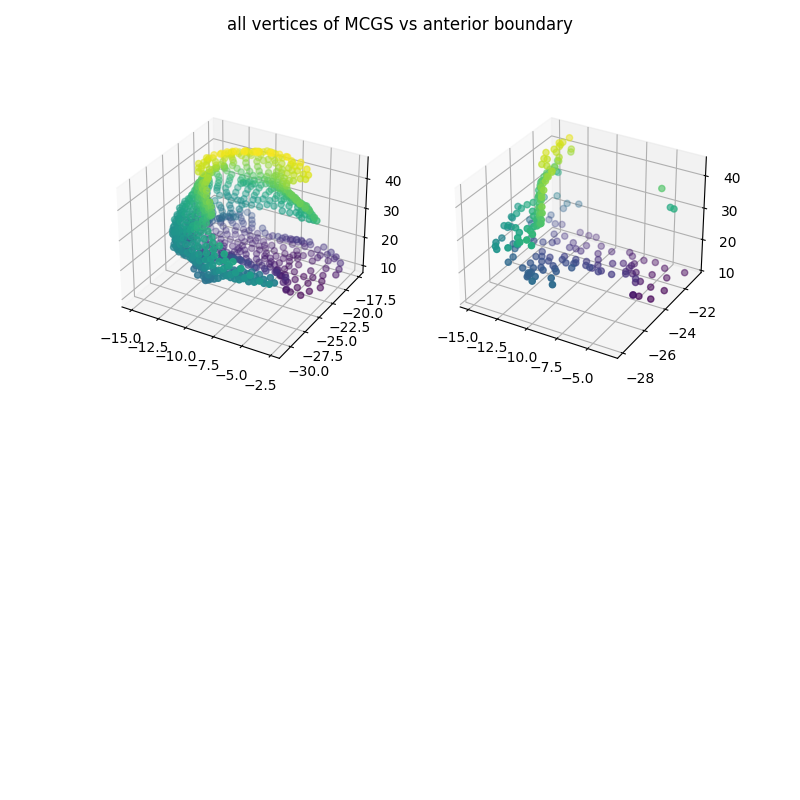

In [ ]:
fig = plt.figure(figsize=(8,8))
ax1 = fig.add_subplot(221, projection='3d')
ax2 = fig.add_subplot(222, projection='3d')
ax1.scatter3D(r_data, a_data, s_data, cmap='viridis', c=s_data)

# Getting lower bound of the sulcus

ax2.scatter3D(test_r_data_min_inferior, test_a_data_min_inferior, test_s_data_min_inferior, cmap='viridis', c=test_s_data_min_inferior, vmin=10, vmax=45)
ax2.set(zlim3d=[10,45]);
plt.suptitle('all vertices of MCGS vs anterior boundary')

## Pycortex

In [ ]:

# project_dir = Path('/Users/benparker/Desktop/cnl/CNL_scalpel/results/')
# subjects_dir = Path('/Users/benparker/Desktop/cnl/subjects/')
# subjects_dir_str = '/Users/benparker/Desktop/cnl/subjects/'

# ## read_annot returns [0] labels at each vertex, -1 for no id [1]: ctab [2]: label names 
# annot_verts, annot_ctab, annot_names = read_annot(subjects_dir / '100307/label/rh.aparc.a2009s.annot')


# # import test subject to pycortex db
# cortex.freesurfer.import_subj('100307', freesurfer_subject_dir=subjects_dir_str, whitematter_surf='white')


In [ ]:


## split FC map by boundary sulci

##### ID vertices within boundary by [0] from read annot

## Mesh traversal

In [272]:
subjects_dir = '/Users/benparker/Desktop/cnl/subjects'
labels = ['POS','MCGS']
sub = '100307'
hemi = 'rh'
outdir = '/Users/benparker/Desktop/cnl/CNL_scalpel/results'

#getDistMatrix(subjects_dir,labels,sub,hemi,outdir, fmri_prep=False)

highres_surface = f'{subjects_dir}/{sub}/surf/{hemi}.pial'
    
 
giidata = nb.freesurfer.read_geometry(highres_surface)
points, faces = giidata[0], giidata[1]

### Do not use nibabel to read_labels because only returns vertices, not coordinates
DONT_label_ind = nb.freesurfer.read_label('/Users/benparker/Desktop/cnl/subjects/100307/label/rh.POS.label')

label_faces = faces[label_ind]

label_ind, label_RAS = read_label('/Users/benparker/Desktop/cnl/subjects/100307/label/rh.POS.label')



In [273]:
label_ind

array([13243, 13244, 13251, ..., 35287, 35288, 35289])

In [274]:
label_RAS

array([[ 22.191, -49.065,   0.173],
       [ 21.966, -49.416,   0.577],
       [ 22.166, -49.152,  -0.27 ],
       ...,
       [ 15.147, -27.109, -14.139],
       [ 14.451, -26.8  , -14.015],
       [ 13.454, -26.752, -14.01 ]])

In [275]:
# From all faces in giidata, get the faces in the label
label_faces = get_faces_for_label(faces, label_ind)

In [276]:
label_faces

array([[12445, 13234, 13244],
       [12445, 13244, 12458],
       [12458, 13244, 13252],
       ...,
       [35288, 35289, 35300],
       [35301, 35300, 35289],
       [35289, 35290, 35301]], dtype=int32)

In [271]:

meshplot.plot(points, label_faces)
meshplot.plot(points, faces)


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(33.492891…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(33.492891…

In an alternate plotting library (trimesh)

In [261]:
import trimesh as tm

mesh = tm.Trimesh(vertices= points, faces = faces)

In [264]:
mesh.show()

In [263]:

label_mesh = tm.Trimesh(vertices= points, faces = label_faces)
label_mesh.show()

Check to see the boundary identified by our functions

In [215]:
pos_boundary = get_faces_for_label(faces, boundary_dict['posterior'][0])
pos_boundary

array([[27069, 28094, 28106],
       [27069, 28106, 27081],
       [27081, 28106, 28109],
       ...,
       [35399, 35400, 36302],
       [35400, 35413, 36316],
       [35400, 36316, 36302]], dtype=int32)

In [216]:

boundary_mesh = tm.Trimesh(vertices= points, faces = pos_boundary)
boundary_mesh.show()

    

Closely replicates the disjointed boundary we saw before.    
  
Possibility for solving: Geodesic path between all the points and then get faces


In [285]:
def get_boundary_faces(all_faces, label_ind):
    """
    For a given label, find the faces that are on the boundary of the label
    """
    # Find the unique faces
    faces_in_label = get_faces_for_label(faces, label_ind)
    unique_entry, count = np.unique(faces_in_label, return_counts=True)
    # Get the nodes that only appear once
    boundary_nodes = unique_entry[count == 1]
    # Get the faces that include the boundary nodes
    boundary_faces = np.where(np.isin(all_faces, boundary_nodes))[0]
    # Remove duplicates
    boundary_faces = np.unique(boundary_faces)
    return boundary_faces

pos_boundary = get_boundary_faces(faces, label_ind)
pos_boundary

array([], dtype=int64)

In [286]:
faces_in_label = get_faces_for_label(faces, label_ind)

unique_entry, count = np.unique(faces_in_label.flatten(), return_counts=True)

In [288]:
faces_in_label.flatten()

array([12445, 13234, 13244, ..., 35289, 35290, 35301], dtype=int32)

In [282]:
count

array([2, 4, 4, ..., 4, 4, 2])

In [254]:

boundary_mesh = tm.Trimesh(vertices= points, faces = sec_faces)
boundary_mesh.show()